In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/MyDrive/My First Project.v15i.yolov11"

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [4]:
!pip install ultralytics torch torchvision opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [5]:
!pip install ultralytics

In [6]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import glob
from PIL import Image
import numpy as np

In [9]:
DATASET_PATH = "/content/drive/MyDrive/My First Project.v15i.yolov11"  # Change to your dataset path
IMG_SIZE = 416  # Image size for training

import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Example Vision Transformer

# Load YOLOv10m model
model = YOLO("yolo11s.pt")




100%|██████████| 18.4M/18.4M [00:00<00:00, 422MB/s]


In [10]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Small Vision Transformer

class HybridBackbone(nn.Module):
    def __init__(self, yolo_backbone, transformer):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.transformer = transformer

    def forward(self, x):
        # Extract features using YOLO's CNN backbone
        cnn_features = self.yolo_backbone(x)

        # Transformer expects a different input shape, so adjust it
        b, c, h, w = cnn_features.shape
        cnn_features = cnn_features.view(b, c, -1).permute(2, 0, 1)  # Reshape for transformer input

        # Extract transformer features
        transformer_features = self.transformer(cnn_features)

        # Reshape back to CNN format
        transformer_features = transformer_features.permute(1, 2, 0).view(b, c, h, w)

        return transformer_features

# Extract YOLO's original backbone
yolo_backbone = model.model.model[0]  # This extracts YOLO's backbone

# Load a pretrained Vision Transformer
transformer = vit_b_16(pretrained=True)
transformer.heads = nn.Identity()  # Remove classification head

# Create a new hybrid backbone
hybrid_backbone = HybridBackbone(yolo_backbone, transformer)

# Replace YOLO's backbone with the hybrid version
model.model.model[0] = hybrid_backbone


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 172MB/s]


In [11]:
model.train(
    epochs=50,
    batch=16,
    imgsz=416,
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=6,  # Early stopping with patience 6

    data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml",
)

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml, epochs=50, time=None, patience=6, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

100%|██████████| 755k/755k [00:00<00:00, 111MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 306MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/train/labels... 2436 images, 426 backgrounds, 0 corrupt: 100%|██████████| 2442/2442 [21:35<00:00,  1.88it/s]


train: New cache created: /content/drive/MyDrive/My First Project.v15i.yolov11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [02:16<00:00,  1.95it/s]

val: New cache created: /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.95G      1.844       3.45       1.77         35        416: 100%|██████████| 153/153 [00:44<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

                   all        266        295       0.12       0.21     0.0662     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.33G      1.961      3.002      1.854         15        416: 100%|██████████| 153/153 [00:42<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        266        295     0.0452      0.271     0.0204    0.00745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.35G      2.009      3.009      1.895         19        416: 100%|██████████| 153/153 [00:41<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]

                   all        266        295      0.202      0.117     0.0755     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.42G       1.98      2.902      1.854         29        416: 100%|██████████| 153/153 [00:40<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        266        295      0.227      0.206      0.144       0.06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.45G       1.91      2.856      1.817         20        416: 100%|██████████| 153/153 [00:40<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


                   all        266        295      0.213      0.237      0.212     0.0965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.49G       1.88      2.757        1.8         19        416: 100%|██████████| 153/153 [00:41<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


                   all        266        295      0.241      0.272      0.214      0.099

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.51G      1.828      2.669      1.752         15        416: 100%|██████████| 153/153 [00:40<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


                   all        266        295      0.291       0.26      0.182     0.0883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.57G      1.792      2.581      1.702         19        416: 100%|██████████| 153/153 [00:41<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]


                   all        266        295       0.35      0.288      0.267       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.61G      1.779      2.534      1.699         33        416: 100%|██████████| 153/153 [00:41<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.20it/s]

                   all        266        295      0.355      0.373      0.288      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.65G       1.75       2.48      1.687         14        416: 100%|██████████| 153/153 [00:41<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


                   all        266        295       0.36      0.316       0.31      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.67G      1.726      2.423      1.667         24        416: 100%|██████████| 153/153 [00:40<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


                   all        266        295       0.36      0.425      0.319      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.73G      1.698      2.333      1.636         23        416: 100%|██████████| 153/153 [00:41<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        266        295       0.37      0.381      0.341      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.77G      1.678      2.331      1.638         17        416: 100%|██████████| 153/153 [00:41<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.04it/s]

                   all        266        295       0.43      0.347      0.314      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.81G      1.646      2.282      1.623         16        416: 100%|██████████| 153/153 [00:41<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


                   all        266        295      0.452      0.401      0.371      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.83G      1.646      2.229      1.622         22        416: 100%|██████████| 153/153 [00:40<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        266        295      0.393      0.386       0.36      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.89G      1.633      2.215      1.621         19        416: 100%|██████████| 153/153 [00:41<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


                   all        266        295      0.475      0.371      0.393      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.93G      1.633      2.223      1.616         26        416: 100%|██████████| 153/153 [00:41<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]

                   all        266        295      0.343      0.444      0.362      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.97G      1.586      2.126      1.587         24        416: 100%|██████████| 153/153 [00:41<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]

                   all        266        295      0.534      0.406      0.432      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.99G      1.602      2.147      1.584         22        416: 100%|██████████| 153/153 [00:41<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


                   all        266        295       0.49      0.429      0.415      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.05G      1.564      2.071      1.565         21        416: 100%|██████████| 153/153 [00:41<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]

                   all        266        295      0.645      0.377      0.437       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.09G      1.582      2.119      1.586         25        416: 100%|██████████| 153/153 [00:41<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]

                   all        266        295      0.471      0.419      0.415      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.13G      1.537      2.017      1.548         17        416: 100%|██████████| 153/153 [00:41<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        266        295       0.58      0.422      0.478      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.14G      1.555      1.999      1.566         20        416: 100%|██████████| 153/153 [00:40<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

                   all        266        295      0.493       0.48      0.469      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.21G      1.537      1.974      1.543         20        416: 100%|██████████| 153/153 [00:41<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

                   all        266        295      0.473      0.484      0.462      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.39G        1.5      1.923      1.519         35        416: 100%|██████████| 153/153 [00:41<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        266        295      0.541      0.453      0.472      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.43G      1.507      1.904      1.534         20        416: 100%|██████████| 153/153 [00:41<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]

                   all        266        295      0.527      0.471       0.47      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.45G      1.472       1.88      1.513         15        416: 100%|██████████| 153/153 [00:41<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

                   all        266        295      0.592      0.484      0.513      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.51G      1.483      1.874      1.517         24        416: 100%|██████████| 153/153 [00:41<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        266        295      0.496      0.511      0.498      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.55G      1.472      1.842      1.516         19        416: 100%|██████████| 153/153 [00:40<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]

                   all        266        295      0.543       0.51      0.469      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.59G      1.472      1.793      1.498         22        416: 100%|██████████| 153/153 [00:41<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


                   all        266        295      0.665      0.489      0.545      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.61G       1.46      1.769      1.489         19        416: 100%|██████████| 153/153 [00:41<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        266        295      0.571      0.499      0.532      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.67G      1.444      1.751      1.486         15        416: 100%|██████████| 153/153 [00:41<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all        266        295      0.549      0.531      0.517      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.71G      1.438       1.74       1.48         17        416: 100%|██████████| 153/153 [00:41<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        266        295       0.64      0.537      0.566      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.75G      1.409      1.673      1.459         32        416: 100%|██████████| 153/153 [00:41<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]

                   all        266        295      0.639       0.54      0.567      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.77G      1.381      1.647      1.462         10        416: 100%|██████████| 153/153 [00:40<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]

                   all        266        295      0.677      0.534      0.583      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.83G      1.366      1.583      1.432         21        416: 100%|██████████| 153/153 [00:40<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

                   all        266        295      0.584      0.603       0.59      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.87G      1.369      1.605      1.435         17        416: 100%|██████████| 153/153 [00:40<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        266        295      0.595      0.551       0.57        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.91G       1.37      1.581      1.442         18        416: 100%|██████████| 153/153 [00:40<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.18it/s]

                   all        266        295      0.574      0.558      0.567      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.94G      1.356      1.556      1.429         33        416: 100%|██████████| 153/153 [00:40<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]


                   all        266        295      0.549      0.569      0.537      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.02G      1.356      1.553      1.426         23        416: 100%|██████████| 153/153 [00:40<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]

                   all        266        295      0.631      0.526      0.573       0.31


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.07G      1.357      1.386      1.451         11        416: 100%|██████████| 153/153 [00:41<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all        266        295      0.602      0.602      0.619      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.13G      1.322      1.307      1.434          8        416: 100%|██████████| 153/153 [00:40<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


                   all        266        295       0.57      0.613      0.587      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.17G      1.302      1.243      1.414          6        416: 100%|██████████| 153/153 [00:40<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.19it/s]

                   all        266        295      0.667      0.533      0.576      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.24G      1.288      1.211      1.408          9        416: 100%|██████████| 153/153 [00:39<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]

                   all        266        295      0.639      0.612      0.592       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       4.3G      1.256      1.188      1.383         15        416: 100%|██████████| 153/153 [00:40<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


                   all        266        295      0.639      0.604      0.614      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.35G       1.25      1.173      1.381          8        416: 100%|██████████| 153/153 [00:40<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

                   all        266        295      0.687      0.583      0.621      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.38G      1.234      1.136      1.366         12        416: 100%|██████████| 153/153 [00:40<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        266        295      0.642      0.595      0.607      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.47G      1.213      1.112      1.359         11        416: 100%|██████████| 153/153 [00:39<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all        266        295      0.683      0.601      0.619      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.51G      1.186      1.065      1.336          9        416: 100%|██████████| 153/153 [00:39<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all        266        295      0.629      0.641      0.615      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.58G      1.188       1.07      1.351         12        416: 100%|██████████| 153/153 [00:40<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

                   all        266        295      0.628      0.644      0.624      0.347



50 epochs completed in 0.622 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


                   all        266        295      0.628      0.644      0.624      0.346
                 cloth         49         68      0.577      0.721      0.657      0.405
                 glass         60         60      0.776      0.749      0.765      0.407
                 metal         45         55      0.542      0.527      0.516      0.259
               plastic         80        112      0.617       0.58      0.558      0.311
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b809f51a8d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [12]:
metrics = model.val()  # Validate the model

# Extract values correctly
precision = metrics.box.p.mean()  # Mean Precision
recall = metrics.box.r.mean()  # Mean Recall
map50 = metrics.box.map50  # Mean Average Precision @ 50
map50_95 = metrics.box.map  # Mean Average Precision @ 50-95

# Print metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, mAP@50: {map50:.4f}, mAP@50-95: {map50_95:.4f}")

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.71it/s]


                   all        266        295      0.629      0.644      0.624      0.346
                 cloth         49         68      0.576      0.721      0.657      0.407
                 glass         60         60      0.775      0.748      0.765      0.408
                 metal         45         55      0.543      0.527      0.516      0.256
               plastic         80        112      0.622       0.58      0.557      0.313
Speed: 1.0ms preprocess, 4.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train2
Precision: 0.6291, Recall: 0.6442, mAP@50: 0.6240, mAP@50-95: 0.3459



0: 416x416 1 metal, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


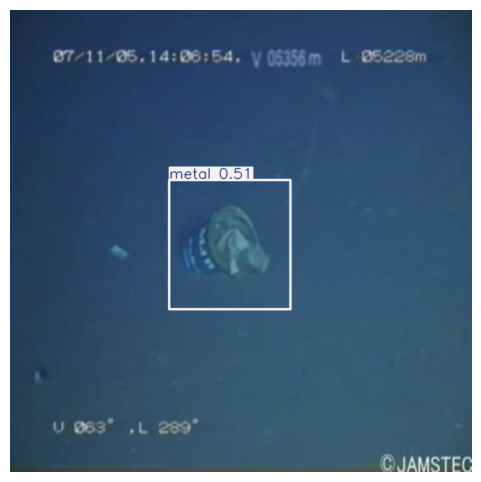

In [13]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import glob

def visualize_results(img_path, model):
    img = Image.open(img_path)
    results = model(img)

    # Extract the first result and get the plotted image
    result_img = results[0].plot()

    # Convert image to NumPy array if it's not already
    result_img = np.array(result_img)

    # Convert BGR (OpenCV default) to RGB for correct display in matplotlib
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # Show image with bounding boxes
    plt.figure(figsize=(6,6))
    plt.imshow(result_img)
    plt.axis("off")
    plt.show()
    plt.pause(0.001)  # Force display update
    plt.close()  # Prevent duplicate figures

# Load test images
test_images = glob.glob("/content/drive/MyDrive/My First Project.v15i.yolov11/test/images/*.jpg")

# Run visualization
if test_images:
    visualize_results(test_images[200], model)
else:
    print("No test images found.")

In [14]:
import glob
model_files = glob.glob("/content/runs/detect/*/weights/best.pt")
print("Available model files:", model_files)

Available model files: ['/content/runs/detect/train/weights/best.pt']


In [15]:
import glob

# List all training runs
train_folders = glob.glob("/content/runs/detect/*/")

print("Available training runs:")
for folder in train_folders:
    print(folder)

Available training runs:
/content/runs/detect/train/
/content/runs/detect/train2/


In [16]:
import glob

# Check logs inside different training folders
for folder in train_folders:
    log_files = glob.glob(folder + "/*.csv")
    if log_files:
        print(f"✅ Logs found in: {folder}")
        print(log_files)
    else:
        print(f"❌ No CSV logs found in: {folder}")

✅ Logs found in: /content/runs/detect/train/
['/content/runs/detect/train/results.csv']
❌ No CSV logs found in: /content/runs/detect/train2/


Available columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


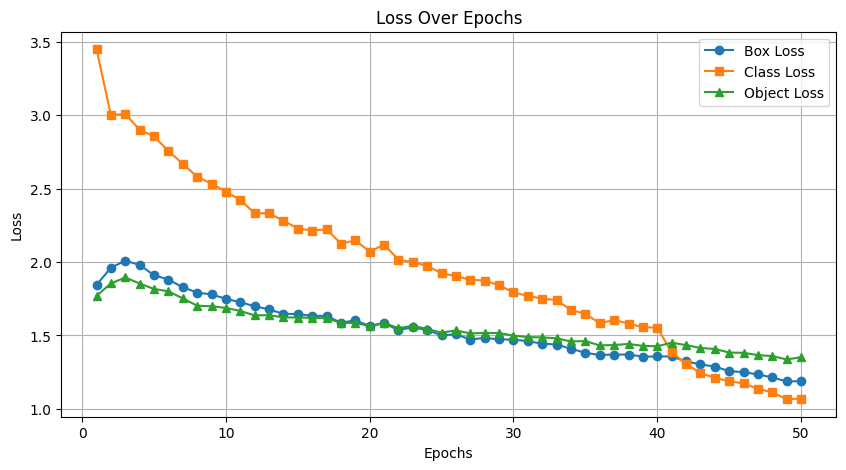

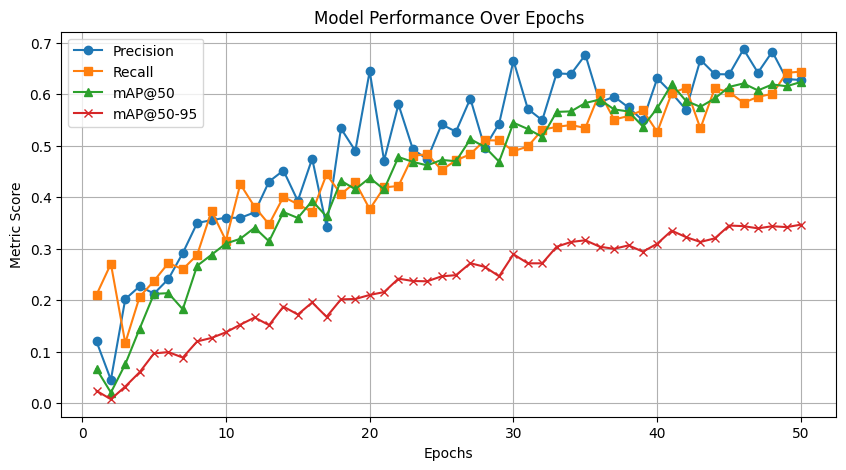

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Load the CSV file
csv_path = "/content/runs/detect/train/results.csv"
df = pd.read_csv(csv_path)

# Print column names to check available metrics
print("Available columns:", df.columns)

# ✅ Force Matplotlib to display the figures
def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss", marker='o')
    plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss", marker='s')
    plt.plot(df["epoch"], df["train/dfl_loss"], label="Object Loss", marker='^')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

def plot_accuracy():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision", marker='o')
    plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall", marker='s')
    plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50", marker='^')
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='x')

    plt.xlabel("Epochs")
    plt.ylabel("Metric Score")
    plt.title("Model Performance Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

# ✅ Call the functions
plot_loss()
plot_accuracy()


In [22]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Evaluate on the test dataset
metrics = model.val(data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml", split="test")

# Extract performance metrics
print("mAP50:", metrics.box.map50)      # Mean Average Precision at IoU 0.5
print("mAP50-95:", metrics.box.map)     # Mean Average Precision at IoU 0.5:0.95
print("Precision:", metrics.box.p.mean())   # Mean Precision across all classes
print("Recall:", metrics.box.r.mean())  # Mean Recall across all classes
print("F1 Score:", metrics.box.f1.mean())  # Mean F1 Score

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/test/labels... 266 images, 46 backgrounds, 0 corrupt: 100%|██████████| 266/266 [02:13<00:00,  1.99it/s]

val: New cache created: /content/drive/MyDrive/My First Project.v15i.yolov11/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]


                   all        266        321      0.644      0.623      0.616      0.326
                 cloth         46         70      0.567      0.571      0.532      0.332
                 glass         59         59      0.782      0.831      0.862      0.447
                 metal         45         56      0.631      0.518       0.54      0.257
               plastic         82        136      0.597      0.574      0.531      0.269
Speed: 1.1ms preprocess, 4.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val2
mAP50: 0.6160990674308858
mAP50-95: 0.326332309790527
Precision: 0.6440018157475738
Recall: 0.6233309001566729
F1 Score: 0.6320327272491125


In [23]:
import shutil

# Define source and destination paths
source_path = "/content/runs/detect/train/weights/best.pt"
destination_path = "/content/yolo11s.pt"

# Ensure the destination folder exists
shutil.os.makedirs("/content/drive/My Drive/saved_models", exist_ok=True)

# Copy the trained model to Google Drive
shutil.copy(source_path, destination_path)

print(f"✅ Model successfully saved to: {destination_path}")

✅ Model successfully saved to: /content/yolo11s.pt
